<a href="https://colab.research.google.com/github/julienroy13/competitive_gradient_descent/blob/master/gan_cgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GAN Training code referenced
 from: https://github.com/afiliot/GANs-And-VAEs-For-Gaussian-Mixture/blob/master/DLIP-MP1-GAN-VAE-FILIOT.ipynb

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

import numpy as np
from torch.distributions.multivariate_normal import MultivariateNormal

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



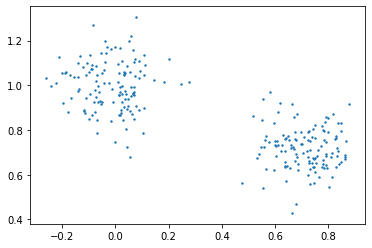

In [49]:
def generate_batch(batchlen,plot=False):
  
  cov = torch.tensor(np.identity(2)*0.01, dtype=torch.float64)
  mu1 = torch.tensor([2**(-1/2), 2**(-1/2)], dtype=torch.float64)
  mu2 = torch.tensor([0,1], dtype=torch.float64)
  
  gaussian1 = MultivariateNormal(loc=mu1, covariance_matrix=cov)
  gaussian2 = MultivariateNormal(loc=mu2, covariance_matrix=cov)

  data = []
  d1 = gaussian1.rsample((int(batchlen/2),))
  d2 = gaussian2.rsample((int(batchlen/2),))

  data = np.concatenate((d1, d2), axis=0)
  np.random.shuffle(data)

  if plot:
    plt.scatter(data[:,0],data[:,1], s=2.0)
  return torch.Tensor(data).to(device)

batch = generate_batch(256, plot=True)


In [0]:
# Define the generator
class Generator(nn.Module):
    def __init__(self, hidden_size=0, noise_size=1, noise_std=1.):
        super().__init__()
        self.noise_size = noise_size
        self.noise_std = noise_std

        # First layer
        self.fc1 = nn.Linear(noise_size, hidden_size)

        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)

        self.fc6 = nn.Linear(hidden_size, 2)


    def __call__(self, z):
        h = F.relu(self.fc1(z))

        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        h = F.relu(self.fc4(h))
        h = F.relu(self.fc5(h))

        return self.fc6(h)

    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, self.noise_size), self.noise_std)
        return self.__call__(z)
    

# Define the discriminator.
class Discriminator(nn.Module):
    def __init__(self, hidden_size=0):
        super().__init__()

        self.fc1 = nn.Linear(2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, 1)


    
    def __call__(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return torch.sigmoid(self.fc6(x))
        # return self.fc6(x)


In [0]:
def GAN(TRAIN_RATIO=1, N_ITER=5000, BATCHLEN=128, hidden_size_G=0, hidden_size_D=0, noise_size=1, noise_std=1., frame=1000):
    """
    TRAIN_RATIO : int, number of times to train the discriminator between two generator steps
    N_ITER : int, total number of training iterations for the generator
    BATCHLEN : int, Batch size to use
    hidden_size_G : int, width of the generator (number of neurons in hidden layers)
    hidden_size_D : int, width of the discriminator (number of neurons in hidden layers)
    noise_size : int, dimension of input noise
    noise_std : float, standard deviation of p(z)
    frame : int, display data each 'frame' iteration
    """

    criterion = nn.BCELoss()

    G = Generator(hidden_size=hidden_size_G, noise_size=noise_size, noise_std=noise_std)
    optimizer_G = torch.optim.SGD(G.parameters(), lr=0.05)
    D = Discriminator(hidden_size=hidden_size_D)
    optimizer_D = torch.optim.SGD(D.parameters(), lr=0.05)

    for i in tqdm(range(N_ITER)):

        # train the discriminator
        D.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = G.generate(BATCHLEN)

        # Compute here the discriminator loss
        h_real = D(real_batch)
        h_fake = D(fake_batch)
        
        loss_real = criterion(h_real, torch.ones((BATCHLEN,1)))
        loss_fake = criterion(h_fake, torch.zeros((BATCHLEN,1)))

        disc_loss = loss_real + loss_fake
        disc_loss.backward(retain_graph=True)
        optimizer_D.step()

        G.zero_grad()
        # real_batch = generate_batch(BATCHLEN)
        # fake_batch = G.generate(BATCHLEN)
        # h_real = D(real_batch)
        # h_fake = D(fake_batch)
        # loss_real = criterion(h_real, torch.ones((BATCHLEN,1)))
        # loss_fake = criterion(h_fake, torch.zeros((BATCHLEN,1)))
        gen_loss =  - loss_real - loss_fake
        gen_loss.backward(retain_graph=True)
        optimizer_G.step()



        # visualization
        if i % frame == 0:
            print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
            print ("loss_real", loss_real)
            print ("loss_fake", loss_fake)
            # for i in G.parameters():
            #   print (i)
            #   break
            print ( list(G.parameters())[0].grad)
            # plot the result
            real_batch = generate_batch(1024)
            fake_batch = G.generate(1024).detach()
            plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
            plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
            plt.show()

step 0: discriminator: 1.385e+00, generator: -1.385e+00
loss_real tensor(0.7032, grad_fn=<BinaryCrossEntropyBackward>)
loss_fake tensor(0.6822, grad_fn=<BinaryCrossEntropyBackward>)
tensor([[ 4.0335e-06, -8.1953e-07,  3.2014e-07,  ...,  3.3876e-06,
         -2.4249e-06, -3.9436e-06],
        [-2.9380e-07,  8.0684e-07,  5.4223e-07,  ...,  1.4770e-06,
          3.2361e-06, -2.3735e-06],
        [-1.7433e-06,  1.3472e-06, -3.0175e-06,  ...,  2.7687e-06,
         -1.6870e-06,  9.1694e-07],
        ...,
        [ 8.0918e-07, -4.1244e-06, -2.6550e-06,  ...,  3.8243e-07,
          1.4594e-06,  1.1271e-06],
        [-5.5898e-07, -4.6644e-06, -6.8666e-07,  ..., -1.9189e-06,
         -1.9370e-06,  1.7504e-06],
        [-2.2241e-06,  7.5581e-07, -1.9369e-06,  ..., -5.9093e-07,
          5.5717e-07, -2.1927e-06]])


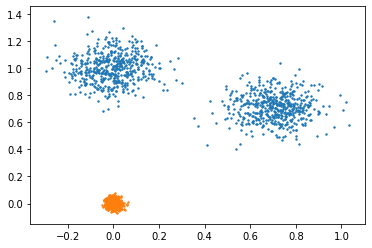

step 100: discriminator: 1.372e+00, generator: -1.372e+00
loss_real tensor(0.7124, grad_fn=<BinaryCrossEntropyBackward>)
loss_fake tensor(0.6601, grad_fn=<BinaryCrossEntropyBackward>)
tensor([[ 7.5575e-07, -3.2475e-06, -1.9156e-05,  ...,  1.3380e-05,
         -1.3978e-05,  6.1484e-06],
        [ 1.0034e-05, -5.4353e-05, -6.5324e-05,  ..., -1.9877e-05,
         -8.9077e-05, -4.8410e-06],
        [-3.2198e-05, -2.6916e-06,  1.1840e-05,  ...,  4.3417e-05,
          1.2236e-05, -7.5072e-06],
        ...,
        [ 5.7542e-05, -1.5229e-05,  2.0028e-05,  ..., -1.1805e-05,
          6.9709e-06,  1.0750e-05],
        [-1.7376e-05,  4.5071e-07, -2.8183e-06,  ...,  1.3060e-05,
         -4.5892e-06,  3.8594e-05],
        [ 2.1969e-06, -8.0445e-06,  2.3547e-05,  ...,  2.1636e-05,
          3.2606e-05, -7.5236e-06]])


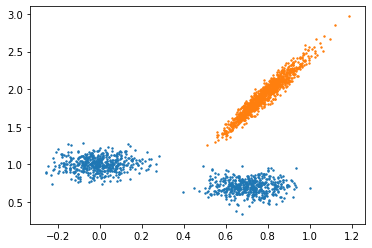

step 200: discriminator: 1.377e+00, generator: -1.377e+00
loss_real tensor(0.7046, grad_fn=<BinaryCrossEntropyBackward>)
loss_fake tensor(0.6726, grad_fn=<BinaryCrossEntropyBackward>)
tensor([[ 1.0754e-04, -1.2655e-04, -2.1225e-04,  ..., -1.3408e-04,
          7.6318e-05, -9.9084e-05],
        [ 1.4982e-04,  4.2864e-05, -1.9668e-04,  ..., -3.1053e-04,
          1.4526e-04,  2.6742e-04],
        [ 3.2666e-05,  1.9965e-05,  1.8570e-04,  ..., -7.6481e-06,
         -3.3719e-05, -6.5254e-05],
        ...,
        [-1.5149e-04, -1.5760e-04, -3.1380e-05,  ...,  9.4250e-05,
          7.0971e-05, -1.9270e-05],
        [-1.2567e-04,  1.0967e-04, -1.3789e-05,  ...,  2.0610e-04,
         -1.0109e-04,  1.5055e-04],
        [-6.9267e-05,  3.2971e-05, -2.1497e-05,  ..., -1.8519e-04,
         -2.4012e-05, -2.4917e-05]])


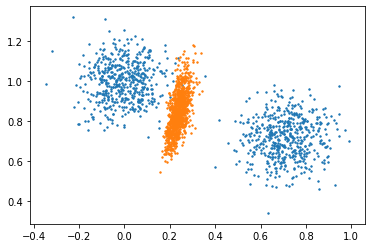

step 300: discriminator: 1.388e+00, generator: -1.388e+00
loss_real tensor(0.6930, grad_fn=<BinaryCrossEntropyBackward>)
loss_fake tensor(0.6947, grad_fn=<BinaryCrossEntropyBackward>)
tensor([[ 5.7450e-06, -1.0730e-05,  4.8451e-06,  ...,  1.3546e-06,
         -7.2640e-06, -2.3622e-05],
        [-3.9371e-06, -2.5422e-05, -2.3422e-06,  ..., -8.7675e-06,
          1.9590e-05,  6.0264e-06],
        [ 1.0545e-05,  7.0437e-06,  9.1628e-06,  ...,  6.9989e-07,
          6.0667e-07, -3.4333e-06],
        ...,
        [ 2.5245e-06,  9.0037e-06, -2.8008e-06,  ...,  6.0008e-06,
         -5.9021e-06, -2.0453e-05],
        [-5.5731e-06, -5.8274e-06,  1.8699e-05,  ...,  4.1646e-06,
         -2.2392e-06, -3.2701e-06],
        [ 6.0779e-06, -3.7971e-06,  1.1150e-05,  ...,  7.3771e-06,
          2.8106e-06, -5.8767e-06]])


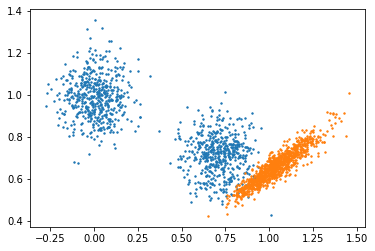

step 400: discriminator: 1.380e+00, generator: -1.380e+00
loss_real tensor(0.6907, grad_fn=<BinaryCrossEntropyBackward>)
loss_fake tensor(0.6896, grad_fn=<BinaryCrossEntropyBackward>)
tensor([[-1.1503e-05,  8.2722e-06, -3.8207e-05,  ..., -5.0537e-05,
          5.0605e-05, -1.8873e-06],
        [-1.4439e-04, -3.4138e-05, -2.9296e-05,  ...,  4.0053e-06,
          2.9625e-05,  7.7849e-06],
        [-6.9635e-05, -5.7890e-05,  2.6301e-05,  ...,  5.8381e-05,
          5.3680e-05,  3.2315e-05],
        ...,
        [-5.5086e-05,  1.5994e-05, -5.5097e-05,  ..., -1.1319e-04,
         -2.5928e-05,  4.7105e-05],
        [ 4.5728e-05,  5.5037e-05,  1.2013e-04,  ..., -6.7185e-05,
          3.6154e-05,  6.6727e-06],
        [ 1.7774e-05, -1.1559e-05, -5.4335e-05,  ...,  7.6009e-06,
         -7.4572e-06,  6.6844e-05]])


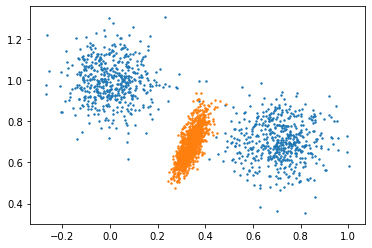

step 500: discriminator: 1.314e+00, generator: -1.314e+00
loss_real tensor(0.6299, grad_fn=<BinaryCrossEntropyBackward>)
loss_fake tensor(0.6839, grad_fn=<BinaryCrossEntropyBackward>)
tensor([[ 7.4118e-05, -2.1378e-04, -4.4034e-04,  ..., -1.0684e-06,
          5.4434e-04, -1.5094e-04],
        [ 3.2391e-04, -3.3397e-04,  7.2603e-06,  ...,  1.9618e-04,
          6.0773e-04,  1.8483e-04],
        [-2.8439e-04, -2.8919e-04, -5.9266e-04,  ...,  3.4219e-04,
          1.1558e-04, -7.3960e-04],
        ...,
        [ 1.2504e-04, -2.5037e-04, -4.5406e-04,  ...,  2.6750e-04,
          7.8236e-05,  5.6902e-05],
        [ 1.1476e-03, -5.0266e-04,  1.8099e-04,  ..., -2.1914e-04,
         -8.8440e-05, -2.6929e-04],
        [-1.3868e-04, -9.9344e-05, -8.3563e-05,  ..., -3.1514e-04,
         -2.0808e-04, -1.6948e-04]])


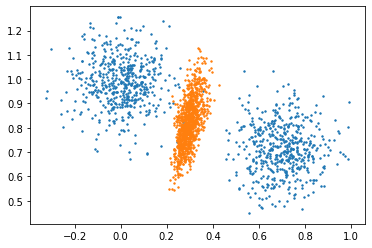

step 600: discriminator: 1.420e+00, generator: -1.420e+00
loss_real tensor(0.7328, grad_fn=<BinaryCrossEntropyBackward>)
loss_fake tensor(0.6872, grad_fn=<BinaryCrossEntropyBackward>)
tensor([[-3.1126e-05,  2.7451e-05, -2.8836e-05,  ...,  8.7643e-05,
          3.4556e-05, -4.2657e-05],
        [-1.7465e-04,  2.7687e-05,  8.1801e-05,  ...,  3.3130e-05,
         -4.7278e-05, -4.8834e-06],
        [-1.8699e-05,  1.3494e-06, -1.9066e-05,  ...,  4.2115e-07,
         -1.5282e-05,  3.5090e-06],
        ...,
        [-5.3482e-06,  2.1550e-05, -3.1861e-05,  ...,  1.2241e-05,
         -3.7796e-05,  1.7052e-05],
        [-1.5318e-05, -8.7807e-06,  2.2452e-05,  ..., -2.8229e-05,
          4.5982e-05, -8.1013e-06],
        [-7.9963e-06, -7.3431e-06, -3.9703e-06,  ...,  5.8169e-06,
          1.1408e-05, -2.2777e-05]])


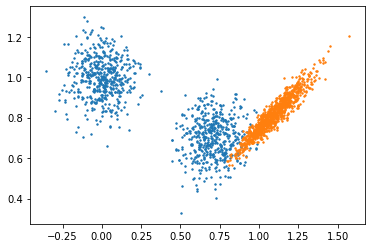

step 700: discriminator: 1.394e+00, generator: -1.394e+00
loss_real tensor(0.7911, grad_fn=<BinaryCrossEntropyBackward>)
loss_fake tensor(0.6029, grad_fn=<BinaryCrossEntropyBackward>)
tensor([[ 5.6587e-05,  2.1389e-05,  4.4173e-05,  ..., -5.7446e-05,
          2.0290e-05,  3.7164e-05],
        [ 3.6933e-05, -6.6710e-05,  9.9958e-05,  ..., -1.0640e-05,
          8.6006e-05,  7.0850e-05],
        [-5.6506e-06,  4.5032e-07, -1.1620e-06,  ...,  2.6672e-05,
         -1.2325e-05,  4.2038e-06],
        ...,
        [ 1.4113e-05,  5.8331e-05,  9.4745e-06,  ..., -1.5803e-05,
          5.3066e-07, -1.0282e-06],
        [-5.3181e-07, -9.5551e-06, -1.0854e-06,  ...,  2.8077e-05,
          1.6388e-05,  1.7116e-05],
        [ 3.8983e-05,  1.8581e-05, -1.2468e-05,  ..., -1.8565e-06,
         -3.1033e-05, -1.8291e-05]])


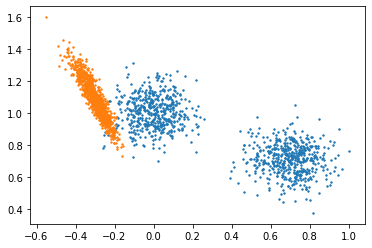

step 800: discriminator: 1.006e+00, generator: -1.006e+00
loss_real tensor(0.4464, grad_fn=<BinaryCrossEntropyBackward>)
loss_fake tensor(0.5601, grad_fn=<BinaryCrossEntropyBackward>)
tensor([[-4.7596e-05, -1.8798e-05, -5.4529e-05,  ..., -6.4877e-05,
         -1.2932e-04, -9.3884e-05],
        [ 6.9053e-05,  2.3598e-04, -5.2381e-05,  ...,  1.0109e-04,
         -2.7244e-04, -1.1342e-04],
        [-1.2771e-04,  9.9369e-05,  5.3091e-05,  ..., -9.0879e-05,
         -6.2912e-05, -3.6372e-05],
        ...,
        [-3.9654e-05, -6.7233e-05, -1.7761e-06,  ..., -3.7013e-06,
         -1.7460e-05, -5.4385e-05],
        [-3.8031e-05,  2.0639e-05, -7.4644e-05,  ...,  3.1877e-05,
         -3.0353e-06, -8.1841e-05],
        [ 3.4333e-05,  4.2359e-05, -1.1554e-04,  ...,  5.3415e-05,
         -3.2801e-05, -7.3044e-05]])


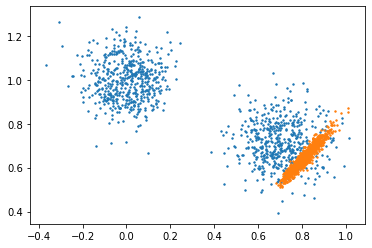

KeyboardInterrupt: ignored

In [60]:
GAN(TRAIN_RATIO=2, N_ITER=5000, BATCHLEN=128,
    hidden_size_G=128, hidden_size_D=128,
    noise_size=512, noise_std=6, frame=100)

In [0]:
G

NameError: ignored

In [0]:
 df_dx = torch.autograd.grad(gen_loss, G.parameters(), create_graph=True)

In [0]:

grads2 = []
for j, (grad, x) in enumerate(zip(df_dx, G.parameters())):
    print('2nd order on ', j, 'th layer')
    print(x.size())
    grad = torch.reshape(grad, [-1])
    grads2_tmp = []
    for count, g in tqdm (enumerate(grad)):
        g2 = torch.autograd.grad(g, x, retain_graph=True)[0]
        g2 = torch.reshape(g2, [-1])
        grads2_tmp.append(g2[count].data.cpu().numpy())
    grads2.append(torch.from_numpy(np.reshape(grads2_tmp, x.size())).to(DEVICE_IDS[0]))


SyntaxError: ignored

In [0]:
H